In [1]:
!pip install -r requirements.txt -q
!sudo apt-get update -q && sudo apt-get install -y libgl1 -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.4.0 requires nvidia-ml-py3<8.0,>=7.352.0, which is not installed.
amazon-sagemaker-jupyter-ai-q-developer 1.2.7 requires numpy<=2.0.1, but you have numpy 2.2.6 which is incompatible.
amazon-sagemaker-sql-magic 0.1.4 requires numpy<2, but you have numpy 2.2.6 which is incompatible.
autogluon-multimodal 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.55.2 which is incompatible.
autogluon-timeseries 1.4.0 requires transformers[sentencepiece]<4.50,>=4.38.0, but you have transformers 4.55.2 which is incompatible.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.6 which is incompatible.
gluonts 0.16.2 requires numpy<2.2,>=1.16, but you have numpy 2.2.6 which is incompatible.
langchain-aws 0.2.19 requires boto3>=1.37.24, but you have boto3 1.3

In [1]:
#manipolazione dati 
import cv2
import numpy as np 
import torch
import torchvision.transforms as transforms
#metriche 
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve

#sistema
import sys
import os
import gc
import time

#displaying a video 
from IPython.display import HTML,display, clear_output

#loading mat
from scipy.io import loadmat
import mat73


#visualizzazione
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def show_frame_in_notebook(frame):
    #Mostra frame in Jupyter Notebook
    clear_output(wait=True)
    display(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    gc.collect()  

In [158]:
#carichiamo mappa binaria (reale) 
frame_img_name=f'video{2}_frame{0}_obs38.png'
binary_map_true = cv2.imread(os.path.join('binary',frame_img_name),cv2.IMREAD_GRAYSCALE)
#converti immagine 0/1
binary_map_true =(binary_map_true > 0).astype(np.uint8)
gaussian_map_true = cv2.imread(os.path.join('gaussian',frame_img_name),cv2.IMREAD_GRAYSCALE)
gaussian_map_true_to_binary=(gaussian_map_true>2).astype(np.uint8)

print('binary shape=>',binary_map_true.shape,'gaussian shape=>',gaussian_map_true.shape)

binary shape=> (720, 1280) gaussian shape=> (720, 1280)


In [161]:
gaussian_map_true_norm = gaussian_map_true / (np.max(gaussian_map_true) + 1e-8)
gaussian_map_true_norm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(720, 1280))

In [162]:
from sklearn.metrics import f1_score

def find_best_threshold(pred_mask, gt_binary):
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_thresh = 0
    for t in thresholds:
        binarized = (pred_mask >= t).astype(np.uint8)
        f1 = f1_score(gt_binary.flatten(), binarized.flatten())
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    return best_thresh, best_f1
best_thresh, best_f1 = find_best_threshold(gaussian_map_true_norm, binary_map_true)
final_binary_mask = (gaussian_map_true_norm >= best_thresh).astype(np.uint8)

In [163]:
best_thresh

np.float64(0.98989898989899)

In [157]:
gaussian_map_true.mean()

np.float64(2.92095703125)

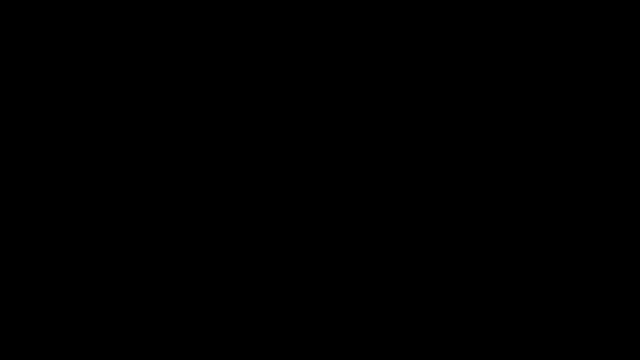

In [143]:
show_frame_in_notebook(cv2.resize(gaussian_map_true_to_binary, (0, 0), fx=0.5, fy=0.5))

In [120]:
#aggiungiamo del rumore
noise_map = np.random.normal(loc=10.0, scale=5.5, size=gaussian_map_true.shape)
gaussian_map_estimated = gaussian_map_true + noise_map 
# Mascheramento: conserva solo il 20% dei pixel
mask = np.random.rand(*gaussian_map_true.shape) > 0.5
gaussian_map_estimated *= mask  

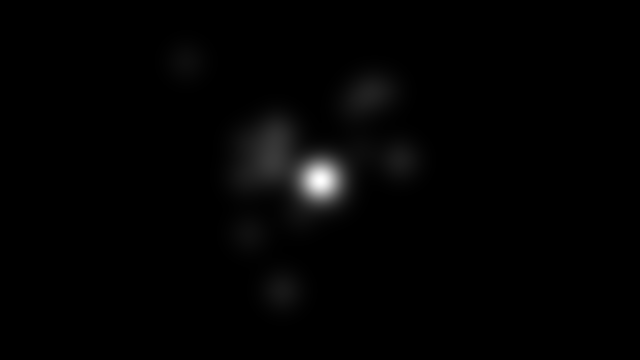

In [77]:
show_frame_in_notebook(cv2.resize(gaussian_map_true, (0, 0), fx=0.5, fy=0.5))

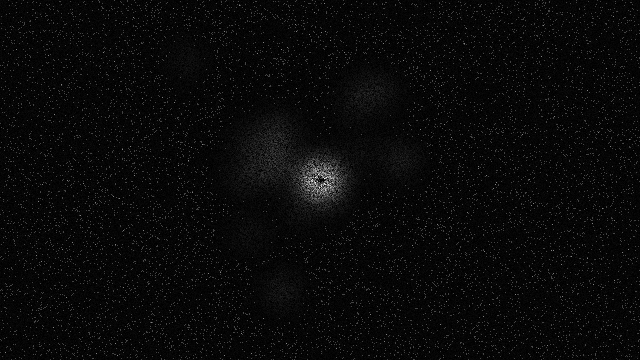

In [121]:
show_frame_in_notebook(cv2.resize(gaussian_map_estimated.astype(np.uint8), (0, 0), fx=0.5, fy=0.5))

### calcola AUC della ROC
> 0.85	0.75 – 0.85	< 0.75	Inflazionato se la mappa è centrata

ROC AUC Score: 0.6836


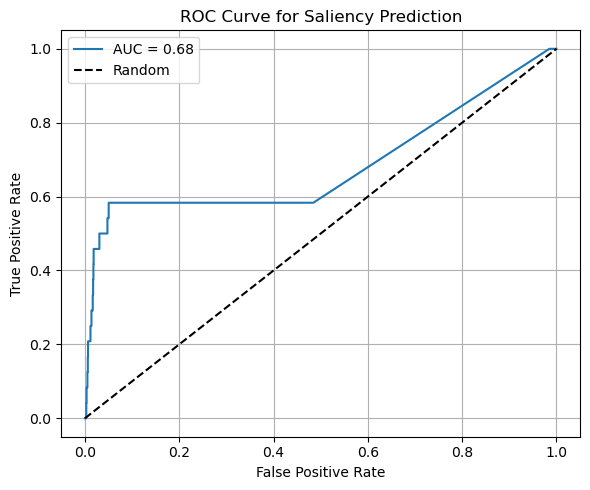

In [127]:
# Flatten both maps for sklearn metrics
y_true = binary_map_true.flatten()
y_pred = gaussian_map_estimated.flatten()
#y_pred = 
# --- ROC AUC ---
auc_score = roc_auc_score(y_true, y_pred)
print(f"ROC AUC Score: {auc_score:.4f}")
#plot
# --- ROC Curve Plot ---
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Saliency Prediction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## confronto binario (output) vs binario (true label)

In [164]:
from sklearn.metrics import precision_score, recall_score, f1_score
def get_f1(y_true,y_pred):
    precision = precision_score(y_true.flatten(), y_pred.flatten())
    recall = recall_score(y_true.flatten(), y_pred.flatten())
    f1 = f1_score(y_true.flatten(), y_pred.flatten())
    return f1 
get_f1(y_true=binary_map_true,y_pred=final_binary_mask)

0.030303030303030304

### Calcola NSS 
    (buono,medio,scarso) > 2.0	1.0 – 2.0	< 1.0

In [122]:
def compute_nss(binary_fixation_map, predicted_saliency_map):
    """
    binary_fixation_map: np.ndarray con valori 0 e 1 (ground truth fissazioni)
    predicted_saliency_map: np.ndarray con valori continui (output modello)
    """
    # Normalizza la mappa predetta: media 0, std 1
    saliency = predicted_saliency_map.astype(np.float32)
    saliency_norm = (saliency - np.mean(saliency)) / (np.std(saliency) + 1e-8)

    # Estrai i valori della mappa normalizzata nei punti di fissazione
    fixation_points = binary_fixation_map.astype(bool)
    n_fixations = np.sum(fixation_points)

    if n_fixations == 0:
        return 0.0  # Evita divisione per zero
    nss_score = np.sum(saliency_norm[fixation_points]) / n_fixations
    return nss_score

In [123]:
#rispetto alla mappa attesa abbiamo valore >0 > 2 quindi ottimo ovviamente
compute_nss(binary_fixation_map=binary_map_true, predicted_saliency_map=gaussian_map_true)
#rispetto al rumore
compute_nss(binary_fixation_map=binary_map_true, predicted_saliency_map=gaussian_map_estimated)

np.float64(1.6360912322998047)

### KL score
    KL Divergence (buono,medio,scarso)	< 0.5	0.5 – 1.0	> 1.0	Più basso è meglio; penalizza sovrastima/sottostima

In [124]:

def normalize_map(m):
    m = np.clip(m, 0, None)  # Rimuove valori negativi
    return m / (np.sum(m) + 1e-8)



def get_kl_score(true,pred):  
    p = normalize_map(true)
    q = normalize_map(pred)
    return np.sum(p * np.log((p + 1e-8) / (q + 1e-8)))

In [126]:
get_kl_score(true=gaussian_map_true,pred=gaussian_map_true)

np.float64(0.0)

In [ ]:
get_kl_score(true=gaussian_map_true,pred=gaussian_map_estimated)

### SIM metric 
    > 0.7	0.5 – 0.7	< 0.5	Simmetrica, misura overlap tra distribuzioni

In [128]:
def similarity(p, q):
    p = p / (np.sum(p) + 1e-8)
    q = q / (np.sum(q) + 1e-8)
    return np.sum(np.minimum(p, q))

In [129]:
similarity(gaussian_map_true, gaussian_map_true)

np.float64(0.9999999999999962)

In [130]:
similarity(gaussian_map_true, gaussian_map_estimated)

np.float64(0.3015394247202466)

In [165]:
similarity(binary_map_true, final_binary_mask)

np.float64(0.023809523803854874)

## corrleation linear
    > 0.6	0.4 – 0.6	< 0.4


In [132]:
def correlation_coefficient(p, q):
    p = (p - np.mean(p)) / (np.std(p) + 1e-8)
    q = (q - np.mean(q)) / (np.std(q) + 1e-8)
    return np.mean(p * q)
correlation_coefficient(gaussian_map_true, gaussian_map_true)    

np.float64(0.999999998639499)

In [166]:
correlation_coefficient(binary_map_true, final_binary_mask)  

np.float64(0.031463607897325614)

### BENCHARMK TOP
    Dataset	Modello top	NSS	AUC-Judd	sAUC	CC	SIM	KL
    MIT300	DeepGaze II	~2.4	~0.88	~0.76	~0.7	~0.75	~0.4
    SALICON	SalGAN	~2.1	~0.86	~0.74	~0.65	~0.7	~0.5